Imports et Utils :
===

In [1]:
import numpy as np
import math
from scipy.optimize import check_grad
from numpy.linalg import inv
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
%matplotlib inline

def load_diabetic_retinopathy(filename, minidata=False):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'diabeticRetinopathy.csv'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
    """

    data = np.loadtxt(filename, delimiter=',')

    y = data[:, -1] * 2 - 1
    X = data[:, :-1]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

Remarques :
===

Ce notebook est écrit en **python3** (et n'est pas compatible python 2 à priori)

On utilse l'opérateur `@` qui équivaut à .dot() : `A@B` équivaut à `A.dot(B)`

Qestion 1.1
===

On note $t_i = y_i(x_i^{\mathsf T}\omega + \omega_0) $

On a :

$\frac{\partial}{\partial \omega_0} log(1 + exp(-t_i)) = \frac{-y_i}{1 + exp(t_i)} $

Pour $j \geq 1$, on a $\frac{\partial}{\partial \omega_j} log(1 + exp(-t_i)) = \frac{-y_i {x_i}_j }{1 + exp(t_i)} $

Le gradient est donc :
$$ \nabla f_1(\omega_0, \omega) = \left(\sum _{i=1}^{n} \frac{-y_i}{1 + exp(t_i)},\sum _{i=1}^{n} \frac{-y_i x_i }{1 + exp(t_i)} + \rho \omega \right)$$

On a : 

$\frac{\partial^2 f}{\partial \omega_{0}^2} = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}exp(y_{i}(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(y_{i}(x_{i}^{T}\omega +\omega _{0})))^2}$

$\frac{\partial^2 f}{\partial \omega^2} = \frac{1}{n}\sum_{i=1}^{n}\frac{(y_{i}x_{i})^{2}exp(y_{i}(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(y_{i}(x_{i}^{T}\omega +\omega _{0})))^2}$

$\frac{\partial^2 f}{\partial \omega\partial \omega_{0}} = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^{2}x_{i}exp(y_{i}(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(y_{i}(x_{i}^{T}\omega +\omega _{0})))^2}$

on obtient la matrice hessienne  :

$H(\omega_{0}, \omega)= \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^{2}exp(y_{i}(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(y_{i}(x_{i}^{T}\omega +\omega _{0})))^2}\begin{pmatrix}
1 &x_{i}^T \\ 
x_{i}^T &  x_{i}x_{i}^T
\end{pmatrix}
+ \rho \begin{pmatrix}
0&0 \\ 
0 &  I_{p}
\end{pmatrix}$

Qestion 1.2
===

In [2]:
def f1(w0, w, rho, X, y):
    n = X.shape[0]
    p = X.shape[1]
    
    #rajout d'une colonne de 1 à X et d'un 1 au début de w
    X_extented = np.concatenate([np.ones((n, 1)), X], axis=1)
    w_extended = np.concatenate([[w0], w])
    
    val = 0
    grad = np.zeros(p+1)
    H = np.zeros((p+1, p+1))
    
    #boucle correspondant à la somme sur i : 
    for i, xi in enumerate(X_extented):
        ti = y[i] * xi@w_extended
        val += 1/n * math.log(1 + math.exp(-ti))
        exp_ti = math.exp(ti)
        grad += -1/n * y[i]*xi / (1 + exp_ti)
        
        #afin que python voit xi_col comme une matrice colonne 
        #pour que @ effectue un produit matricielle et non terme à terme :
        xi_col = xi.reshape((p+1, 1))
        
        H += 1/n * y[i]**2 * xi_col@xi_col.T * exp_ti/(1 + exp_ti)**2
    
    val += rho/2 * w@w
    grad += np.concatenate([[0], w]) * rho
    H += np.diag([0] + [rho] * p)
    return val, grad, H

Vérification du gradient :
===

In [3]:
X, y = load_diabetic_retinopathy("diabeticRetinopathy.csv")
n = X.shape[0]
p = X.shape[1]
rho = 1/n

func = lambda w0_w : f1(w0_w[0], w0_w[1:], rho, X, y)[0]
grad = lambda w0_w : f1(w0_w[0], w0_w[1:], rho, X, y)[1]
hess = lambda w0_w : f1(w0_w[0], w0_w[1:], rho, X, y)[2]

nb_tests = 10
error_grad = 0
for _ in range(nb_tests):
    x0 = np.random.uniform(-1, 1, p+1)
    error_grad += check_grad(func, grad, x0) / norm(grad(x0))
print(error_grad/nb_tests)

7.392407607510548e-07


L'erreur est extrèmement faible, le calcul du gradient est valide.

Vérification de la hessienne :
===

Une ligne de la hessienne correspond au gradient d'une cordonnée du gradient :

$$ \nabla ( (\nabla f_1(\omega_0, \omega))_i ) = ( {H_i}_1, {H_i}_2, ..., {H_i}_p) $$ 

Cela nous permet de vérifier la hessienne ligne par ligne avec `check_grad`

In [4]:
nb_tests = 3
error_hess = 0
for _ in range(nb_tests):
    x0 = x0 = np.random.uniform(-1, 1, p+1)
    for i in range(p):
        grad_i = lambda w0_w : grad(w0_w)[i]
        hess_i = lambda w0_w : hess(w0_w)[i]
        error_hess += check_grad(grad_i, hess_i, x0) / norm(hess_i(x0))
print(error_hess/nb_tests/p)

2.5814961040799336e-07


L'erreur est également très faible. Le calcul de la hessienne est valide.

Question 1.3
===

La valeur minimale approchée est 0.5300


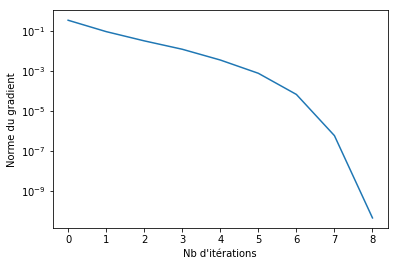

In [5]:
def newtons_method(w0, w, rho, X, y, epsilon=10**-10, trace=False):
    _, grad, hess = f1(w0, w, rho, X, y)
    it = 0
    norms = []
    while(norm(grad) >= epsilon):
        if(trace):
            norms.append(norm(grad)) 
        delta = inv(hess) @ grad
        w0 -= delta[0]
        w -= delta[1:]
        _, grad, hess = f1(w0, w, rho, X, y)
        it += 1
    if(trace):
        norms.append(norm(grad))
        plt.semilogy([k for k in range(it+1)] , norms)
        plt.ylabel("Norme du gradient")
        plt.xlabel("Nb d'itérations")
        
    return w0, w

w0_star, w_star = newtons_method(0, np.zeros(p), rho, X, y, 10**-10, True)
print("La valeur minimale approchée est %.4f" % (f1(w0_star, w_star, rho, X, y)[0]))

Question 1.4
===

In [6]:
try:
    newtons_method(0.3, 0.3 * np.ones(p), rho, X, y)
except OverflowError as e:
    print("La méthode diverge, on obtient l'erreur python :")
    print(e)

La méthode diverge, on obtient l'erreur python :
(34, 'Result too large')


##### Commentaire :

Cela correspond à la situation décrite dans le cours : "*Out of the region of quadratic convergence, Newton's method may diverge*"

Pour pallier à cela, on améliore la méthode avec une recherche linéaire.

Question 1.5
===

In [7]:
def armijo_line_search(f, grad, x, x_plus, a = 0.2, b = 1, beta = 0.001):
    initial_val = f(x)
    l = 0
    x_l = x_plus(b * a**l)
    while(f(x_l) - initial_val > beta * grad @ (x_l - x)):
        l += 1
        x_l = x_plus(b * a**l)
    return x_l

Les valeurs de $a$ et $\beta$ sont des choix classiques pour la méthode d'Armijo. Et ces valeurs donnent de très bons résultats ici (cf graphique en dessous). Si cela n'avait pas était le cas, on aurait pu éventuellement procéder à un "gird search" ou autre pour trouver de bonnes valeurs pour ces paramètres.

Le choix de $b$ s'impose logiquement : on ne souhaite pas faire de "pas" plus grand que pour la méthode de Newton normale puisque ce sont justement de trop grand pas qui amène la méthode à diverger.

La valeur minimale approchée est 0.5300


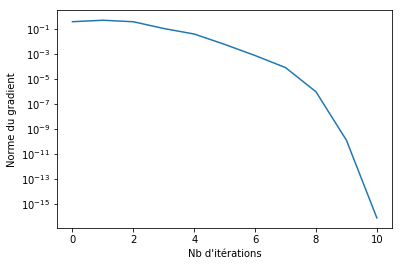

In [8]:
def improved_newtons_method(w0, w, rho, X, y, epsilon=10**-10, trace=False):
    _, grad, hess = f1(w0, w, rho, X, y)
    it = 0
    norms = []
    f = lambda w_extended : f1(w_extended[0], w_extended[1:], rho, X, y)[0]
    while(norm(grad) >= epsilon):
        if(trace):
            norms.append(norm(grad)) 
        tmp = inv(hess) @ grad
        w_extended = np.concatenate([[w0], w])
        w_plus = lambda gamma : w_extended - gamma * tmp
        w_armijo = armijo_line_search(f, grad, w_extended, w_plus)
        w0 = w_armijo[0]
        w = w_armijo[1:]
        _, grad, hess = f1(w0, w, rho, X, y)
        it += 1
    if(trace):
        norms.append(norm(grad))
        plt.semilogy([k for k in range(it+1)] , norms)
        plt.ylabel("Norme du gradient")
        plt.xlabel("Nb d'itérations")
        
    return w0, w 

w0_star, w_star = improved_newtons_method(0.3, 0.3 * np.ones(p), rho, X, y, 10**-12, True)
print("La valeur minimale approchée est %.4f" % (f1(w0_star, w_star, rho, X, y)[0]))

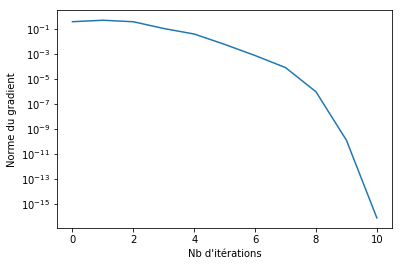

In [9]:
%prun improved_newtons_method(0.3, 0.3 * np.ones(p), rho, X, y, 10**-12, True)

Question 2.1
===

La présence de la norme 1 empèche de différencier l'expression. La méthode de Newton n'est donc pas appliquable.

Question 2.2
===
$F_{2}  (\omega_0, \omega) = \frac{1}{n}\sum_{i=1}^{n}log(1+exp(-y_{i}(x_{i}^T\omega +\omega_{0}))) + \rho \left \| \omega \right \|
_{1} = f_{2} (\omega_0, \omega) + g_{2} (\omega)$


avec $f_{2}  (\omega_0, \omega)= \frac{1}{n}\sum_{i=1}^{n}log(1+exp(-y_{i}(x_{i}^T\omega +\omega_{0})))$ et $g_{2}  (\omega)= \rho \left \| \omega \right \|_{1} $

D'après la question 1.1, le gradient de $f_{2}$ est:

$\triangledown f_{2} (\omega_0, \omega) = \frac{1}{n}\sum_{i=1}^{n}\frac{-y_{i}}{1+exp(y_{i}(x_{i}^{T}\omega +\omega _{0}))}\begin{pmatrix}
1\\x_{i} 
\end{pmatrix}$

Question 2.3
===

On choisit la condition d'arrêt suivante : $\|x_{k+1} - x_k\|_1 < \epsilon$

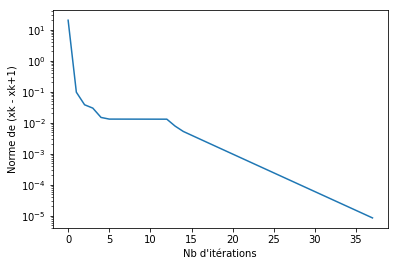

In [10]:
def prox_abs(x, gamma):
    if(x < -gamma):
        return x + gamma
    elif(x > gamma):
        return x - gamma
    else:
        return 0.
    
prox_norm1 = lambda gamma : np.vectorize(lambda x : prox_abs(x, gamma)) 

def f2(w0, w, rho, X, y):
    n = X.shape[0]
    p = X.shape[1]
    
    #rajout d'une colonne de 1 à X et d'un 1 au début de w
    X_extented = np.concatenate([np.ones((n, 1)), X], axis=1)
    w_extended = np.concatenate([[w0], w])
    
    val = 0
    grad = np.zeros(p+1)
    
    # somme sur i = 1 ... n : 
    for i, xi in enumerate(X_extented):
        ti = y[i] * xi@w_extended
        val += 1/n * math.log(1 + math.exp(-ti))
        exp_ti = math.exp(ti)
        grad += -1/n * y[i]*xi / (1 + exp_ti)

    return val, grad

def g2(w, rho):
    return norm(w, ord=1)

def F2(w0, w, rho, X, y):
    return f2(w0, w, rho, X, y)[0] + g2[0]

def proximal_gradient(w0_0, w_0, rho, X, y, epsilon=10**-5, trace=False):
    w_extended = np.concatenate([[w0_0], w_0])
    _, grad = f2(w0_0, w_0, rho, X, y)
    it = 0
    norms = []
    w_last = w_extended + np.ones(w_extended.size) 
    f = lambda w_extended : f2(w_extended[0], w_extended[1:], rho, X, y)[0]
    while(norm(w_extended - w_last, ord=1) >= epsilon):
        if(trace):
            norm(w_extended - w_last, ord=1)
            norms.append(norm(w_extended - w_last, ord=1))
        w_last = w_extended
        w_plus = lambda gamma : prox_norm1(rho * gamma)(w_extended - gamma * grad)
        w_extended = armijo_line_search(f, grad, w_extended, w_plus)
        _, grad = f2(w_extended[0], w_extended[1:], rho, X, y)
        it += 1
    if(trace):
        norms.append(norm(w_extended - w_last, ord=1))
        plt.semilogy([k for k in range(it+1)] , norms)
        plt.ylabel("Norme de (xk - xk+1)")
        plt.xlabel("Nb d'itérations")
    return w_extended[0], w_extended[1:]

w0_start, w_star = proximal_gradient(0, 0 * np.ones(p), 0.1, X, y, 10**-5, True)

Question 3.1
===

Les deux problèmes sont très similaires. La fonction objective soujacente commune est $f_2$. Cette fonction objective soujacente est pénalisée par la norme 2 pour le problème 1 et par la norme 1 pour le problème de la partie 2. 

Cela conduit à des comportements différents.

Question 3.2
===

#### Comparaisions des résultats pour $(\omega_0^0, \omega^0) = 0$ :

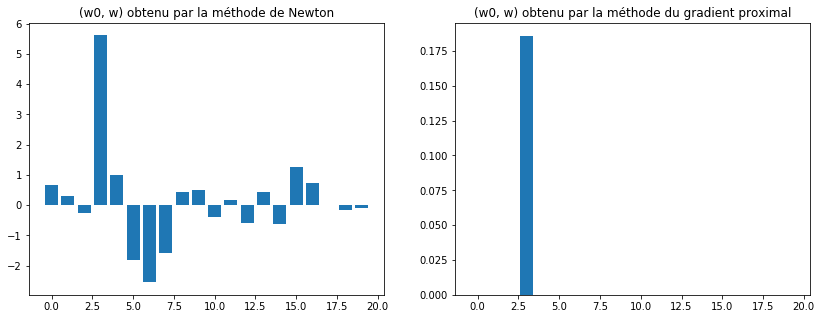

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(ax1)
w0_star, w_star = newtons_method(0, np.zeros(p), rho, X, y, 10**-10)
plt.bar(x=list(range(20)), height=np.concatenate([[w0_star], w_star]))
plt.title("(w0, w) obtenu par la méthode de Newton")

plt.subplot(ax2)
w0_star, w_star = proximal_gradient(0, 0 * np.ones(p), 0.1, X, y, 10**-5)
plt.bar(x =list(range(20)) ,height= np.concatenate([[w0_star], w_star]))
t = plt.title("(w0, w) obtenu par la méthode du gradient proximal")

La pénalisation $\|.\|_1$ donne une solution beaucoup plus "simple" (tout à zéro sauf une coordonnée). La forme de la solution est un peu préservée : la coordonné "dominante" est la même

#### Comparaisions des résultats pour $(\omega_0^0, \omega^0) = 0.3e$ :

Les $(\widehat{\omega_0},\widehat{\omega})$ trouvés sont dans ce cas très différent pour les 2 types de régularisations.

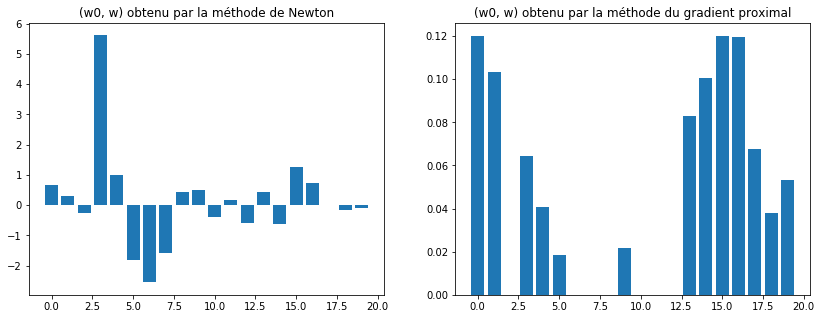

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(ax1)
w0_star, w_star = improved_newtons_method(0.3, 0.3 * np.ones(p), rho, X, y, 10**-10)
plt.bar(x=list(range(20)), height=np.concatenate([[w0_star], w_star]))
plt.title("(w0, w) obtenu par la méthode de Newton")

plt.subplot(ax2)
w0_star, w_star = proximal_gradient(0.3, 0.3 * np.ones(p), 0.1, X, y, 10**-5)
plt.bar(x =list(range(20)) ,height= np.concatenate([[w0_star], w_star]))
t = plt.title("(w0, w) obtenu par la méthode du gradient proximal")

Pour le fun : 
===
#### Comparaisons des résulats en termes de prédictions face à la régression logistique de `sklearn`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(X_test @ w_star + w0_star > 0).astype(int) * 2 - 1

def my_score1(X_train, X_test, y_train, y_test):
    w0_star, w_star = improved_newtons_method(0.3, 0.3 * np.ones(p), rho, X_train, y_train, 10**-8)
    
    return 1 - np.sum(abs((X_test @ w_star + w0_star > 0).astype(int) * 2 - 1 - y_test))/(2*y_test.size)

print("Méthode de Newton améliorée :")
print("Taux de prédictions fructueuses : %.3f" % my_score1(X_train, X_test, y_train, y_test))
print()

def my_score2(X_train, X_test, y_train, y_test):
    w0_star, w_star = proximal_gradient(0.3, 0.3 * np.ones(p), 0.1, X, y, 10**-5)
    
    return 1 - np.sum(abs((X_test @ w_star + w0_star > 0).astype(int) * 2 - 1 - y_test))/(2*y_test.size)
    
print("Méthode du gradient proximal :")
print("Taux de prédictions fructueuses : %.3f" % my_score2(X_train, X_test, y_train, y_test))
print()

def skl_score(X_train, X_test, y_train, y_test, penalty='l2', C=1/rho):
    logistic = linear_model.LogisticRegression(penalty=penalty, tol=10**-8, C=C, fit_intercept=True)
    logistic.fit(X_train, y_train)
    return 1 - np.sum(abs((logistic.predict(X_test) - y_test)))/(2*y_test.size)

print("Régression logistique (pénalisation norme 2) de scikit-learn :")
print("Taux de prédictions fructueuses : %.3f" % skl_score(X_train, X_test, y_train, y_test))
print()

print("Régression logistique (pénalisation norme 1) de scikit-learn :")
print("Taux de prédictions fructueuses : %.3f" % skl_score(X_train, X_test, y_train, y_test, 'l1', 10))

Méthode de Newton améliorée :
Taux de prédictions fructueuses : 0.705

Méthode du gradient proximal :
Taux de prédictions fructueuses : 0.601

Régression logistique (pénalisation norme 2) de scikit-learn :
Taux de prédictions fructueuses : 0.754

Régression logistique (pénalisation norme 1) de scikit-learn :


### Conclusion :
Scikit-learn est meilleur, il serait intéressant de déterminer quels sont les facteurs qui mène à ces différences de performances.


Une erreur de calcul ou d'implémentation a probablement été commise pour la méthode du gradient proximal.